In [63]:
%matplotlib inline
import os
import numpy as np

import readdy_learn.analyze.generate as generate
import readdy_learn.generate.generate_tools.kinetic_monte_carlo as kmc
import readdy_learn.analyze.basis as basis
import readdy_learn.analyze.sklearn as rlas
import readdy_learn.analyze.tools as tools
import readdy_learn.analyze.derivative as deriv
import readdy_learn.sample_tools as sample_tools

if True:
    import matplotlib as mpl
    mpl.rcParams['xtick.labelsize'] = 48
    mpl.rcParams['ytick.labelsize'] = 48

    mpl.rcParams['xtick.major.pad'] = 10
    mpl.rcParams['ytick.major.pad'] = 5

    mpl.rcParams['xtick.major.size'] = 12
    mpl.rcParams['xtick.major.width'] = 2
    mpl.rcParams['xtick.minor.size'] = 8
    mpl.rcParams['xtick.minor.width'] = 1

    mpl.rcParams['ytick.major.size'] = 14
    mpl.rcParams['ytick.major.width'] = 2
    mpl.rcParams['ytick.minor.size'] = 8
    mpl.rcParams['ytick.minor.width'] = 1

    mpl.rc('font',**{'family':'serif','serif':['Arial'],'size':48})
    mpl.rc('text', usetex=True)
    mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

    mpl.rc('legend', fontsize=30)

    mpl.rcParams['figure.figsize'] = (15, 15)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [66]:
timestep = 1e-4
n_steps=100
n_species = 4
# interp_degree >= 0: interpolate with polynomials
# interp_degree < 0: interpolate with curve fit (actual value has no influence)
# interp_degree = 'pw_linear': piecewise linear interpolation of counts
# interp_degree = 'SINDy': maybe this works, todo
interp_degree='pw_linear'
desired_rates = np.array([.02, .02, .01, 1e-4, 1e-4, 0,0,0,0,0,0,0, 0])
initial_state = np.array([[70, 50, 30, 50]])
n_gillespie_realizations = 1

traj_counts_fname = 'aux_traj_counts.npy'

plot_linear_approximation_fname = 'aux_linear_approximation.eps'

In [50]:
def set_up_system(init_state):
    sys = kmc.ReactionDiffusionSystem(n_species=4, n_boxes=1, diffusivity=[[[0.]], [[0.]], [[0.]], [[0.]]],
                                      init_state=init_state, species_names=["A", "B", "C", "D"])
    sys.add_conversion("A", "D", np.array([desired_rates[0]]))
    sys.add_conversion("D", "A", np.array([desired_rates[1]]))
    sys.add_conversion("D", "B", np.array([desired_rates[2]]))
    sys.add_fusion("A", "B", "C", np.array([desired_rates[3]]))
    sys.add_fission("C", "D", "B", np.array([desired_rates[4]]))

    return sys
def get_bfc():
    bfc = basis.BasisFunctionConfiguration(n_species=n_species)
    bfc.add_conversion(0, 3)  # A -> D
    bfc.add_conversion(3, 0)  # D -> A
    bfc.add_conversion(3, 1)  # D -> B
    
    bfc.add_fusion(0, 1, 2) # A + B -> C
    bfc.add_fission(2, 3, 1) # C -> D + B
    
    bfc.add_conversion(0, 1)
    bfc.add_conversion(0, 1)
    bfc.add_fusion(0, 2, 3)
    bfc.add_fusion(0, 3, 2)
    bfc.add_fission(3, 0, 2)
    bfc.add_fission(2, 0, 1)
    bfc.add_fission(2, 0, 1) # C -> A + B, nope
    bfc.add_conversion(0, 1) # A -> B, nope
    return bfc
def get_traj():
    if not os.path.exists(traj_counts_fname):
        times, counts = generate.generate_averaged_kmc_counts(lambda: set_up_system(initial_state), n_steps, 
                                                          timestep, n_realizations=n_gillespie_realizations)
        np.save(traj_counts_fname, counts)
    else:
        counts = np.load(traj_counts_fname)
        times = np.linspace(0, float(counts.shape[0]) * float(timestep), num=counts.shape[0], endpoint=False)
    traj = tools.Trajectory(counts, timestep, interpolation_degree=interp_degree, verbose=False)
    traj.update()
    return traj

In [51]:
traj = get_train_traj()
system = set_up_system(init_state=initial_state)
suite = sample_tools.Suite.from_trajectory(traj, system, get_bfc())
estimator = estimator = suite.get_estimator(interp_degree=interp_degree)

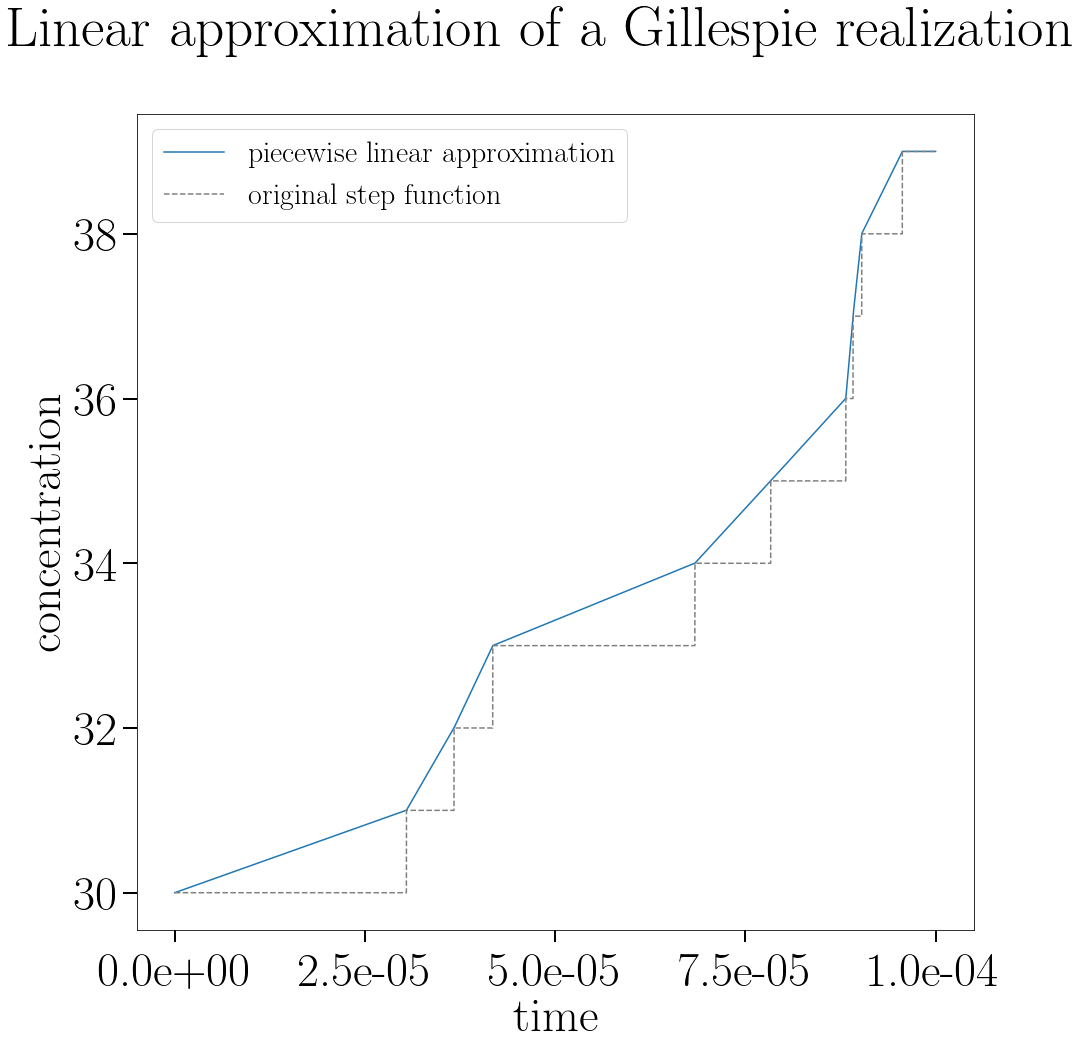

In [70]:
dt = traj.time_step
X = np.linspace(0, 1, num=traj.n_time_steps) * dt

theta = estimator.get_theta(traj.counts)
theta = np.transpose(theta, axes=(0, 2, 1))
dx = theta.dot(desired_rates)

fig, ax1 = plt.subplots(nrows=1, ncols=1)

fig.suptitle('Linear approximation of a Gillespie realization')

ax1.set_xlabel('time')
ax1.set_ylabel('concentration')
ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

for s in [2]:
    counts = traj.counts[:, s]
    indices = 1 + np.where(counts[:-1] != counts[1:])[0]
    indices = np.insert(indices, 0, 0)
    indices = np.append(indices, len(counts) - 1)
    
    ff = np.interp(X, X[indices], counts[indices])
    ax1.plot(X, ff, label='piecewise linear approximation')
    ax1.plot(X, counts, '--', color='grey', label='original step function')

ax1.legend()
fig.savefig(plot_linear_approximation_fname)
plt.show()